### 1. GAN first introduction
![GAN picture](./gan.png)



GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

### 2. Define the neural networks in pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
1.13.0+cu117


Let's define a small 2-layer fully connected neural network (so one hidden layer) for the discriminator D:

In [2]:
class Discriminator(nn.Module):
    def __init__(self, image_channels=1, features=32):
        super(Discriminator, self).__init__()
        # define the model
        self.model = nn.Sequential(
            # define the first Conv block
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Conv block 2 
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
    
            # Conv block 3
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            # Conv block 4
            nn.Conv2d(features*4, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

And a small 2-layer neural network for the generator G. G takes a 100-dimensional noise vector and generates an output of the size matching the data.

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_channels=100, image_channels=1, features=24):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Transpose block 1
            nn.ConvTranspose2d(noise_channels, features*8, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            # Transpose block 2
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            # Transpose block 3
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Last transpose block (different)
            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)

In [4]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 192, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(1, 1))
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1,

Loading the data and computing forward pass

In [5]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Let's look at a sample:

### Putting it all together: the full training loop

Modifications to the code:
* add device parameter to take GPU if available
* use [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) (an adaptive learning-rate variation of SGD with momentum)
* some very minimal logging

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
criterion = nn.BCELoss()
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0005)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0005)
D_loss = []
G_loss = []
data_num = len(dataloader.dataset)

# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

epochs = 10
for epoch in range(epochs): # 3 epochs
    d_loss = 0.
    g_loss = 0.
    for i, (x_real, _) in enumerate(dataloader):
        x_real = x_real.to(device)
        batch_size = x_real.shape[0]
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()
        label = (torch.ones(batch_size)).to(device)

        D_x = D(x_real).reshape(-1)
        lossD_real = criterion(D_x, label)

        z = torch.randn(batch_size, 100, 1, 1, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        label = (torch.ones(batch_size) * 0).to(device)
        D_G_z = D(x_gen).reshape(-1)
#         print("l", label.shape)
#         print("b", D_G_z.shape)
        lossD_fake = criterion(D_G_z, label)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(batch_size, 100, 1, 1, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        label = (torch.ones(batch_size)).to(device)
        D_G_z = D(x_gen).reshape(-1)
        lossG = criterion(D_G_z, label) # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        
        with torch.no_grad():
            d_loss += lossD
            g_loss += lossG
            
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())
    
    with torch.no_grad():
        D_loss.append(d_loss / data_num)
        G_loss.append(g_loss / data_num)
        print('Epoch:', epoch, "D Loss:", d_loss / data_num, "G Loss", g_loss / data_num)

Device:  cuda
Epoch: 0 D Loss: tensor(0.0082, device='cuda:0') G Loss tensor(0.4583, device='cuda:0')
Epoch: 1 D Loss: tensor(0.0200, device='cuda:0') G Loss tensor(0.0223, device='cuda:0')
Epoch: 2 D Loss: tensor(0.0176, device='cuda:0') G Loss tensor(0.0208, device='cuda:0')
Epoch: 3 D Loss: tensor(0.0170, device='cuda:0') G Loss tensor(0.0212, device='cuda:0')
Epoch: 4 D Loss: tensor(0.0163, device='cuda:0') G Loss tensor(0.0225, device='cuda:0')
Epoch: 5 D Loss: tensor(0.0156, device='cuda:0') G Loss tensor(0.0236, device='cuda:0')
Epoch: 6 D Loss: tensor(0.0153, device='cuda:0') G Loss tensor(0.0242, device='cuda:0')
Epoch: 7 D Loss: tensor(0.0151, device='cuda:0') G Loss tensor(0.0247, device='cuda:0')
Epoch: 8 D Loss: tensor(0.0150, device='cuda:0') G Loss tensor(0.0252, device='cuda:0')
Epoch: 9 D Loss: tensor(0.0146, device='cuda:0') G Loss tensor(0.0258, device='cuda:0')


<Figure size 640x480 with 0 Axes>

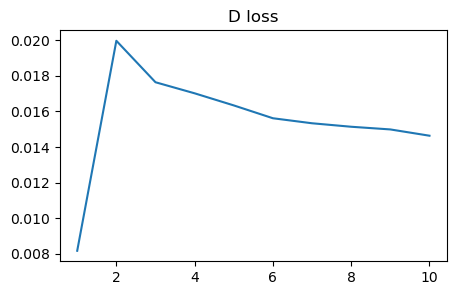

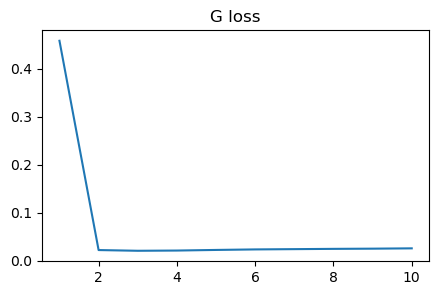

In [12]:
D_loss = [i.data.cpu().numpy() for i in D_loss]
G_loss = [i.data.cpu().numpy() for i in G_loss]

# for i in range(epochs):
#     D_loss[i] = D_loss[i].data.cpu().numpy()
#     G_loss[i] = G_loss[i].data.cpu().numpy()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), D_loss)
plt.title('D loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), G_loss)
plt.title('G loss');

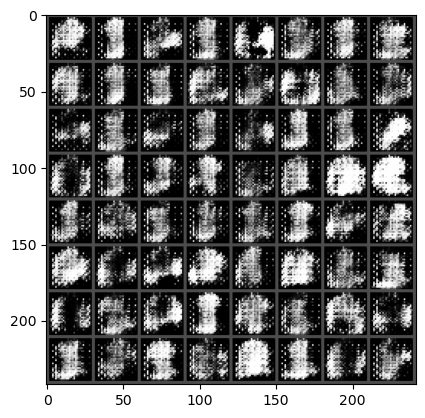

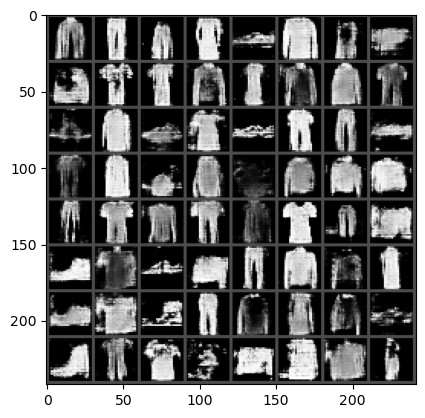

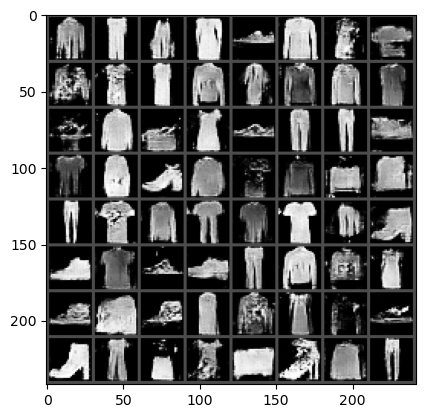

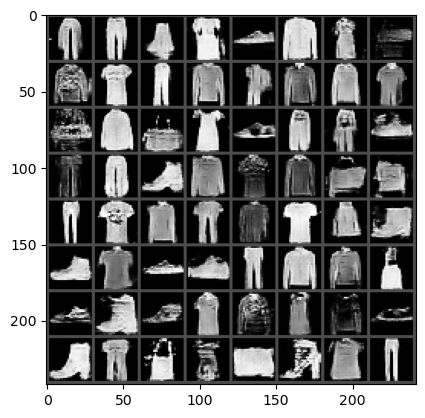

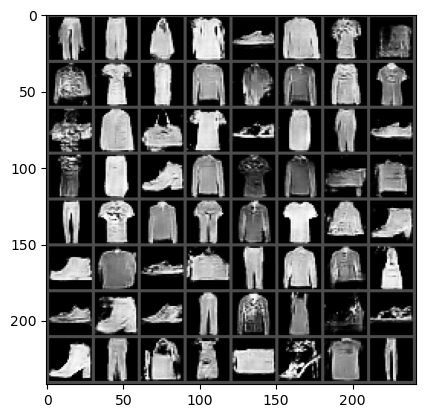

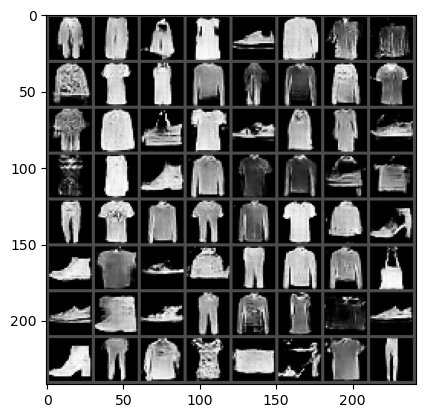

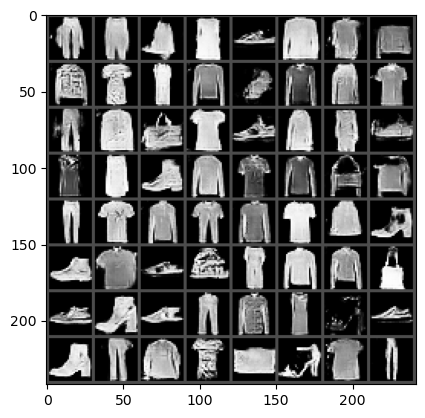

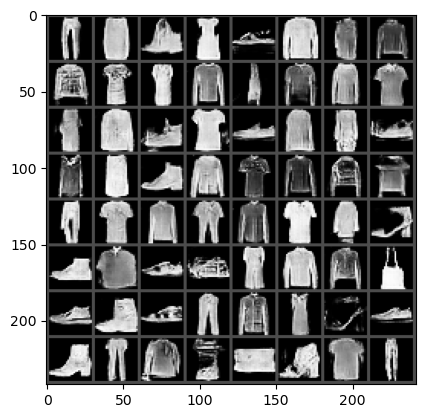

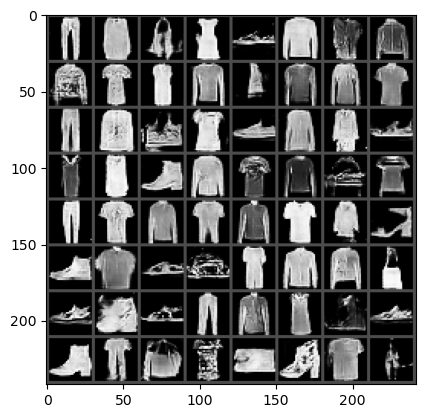

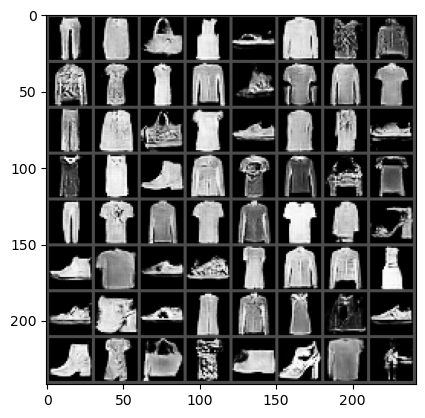

In [13]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

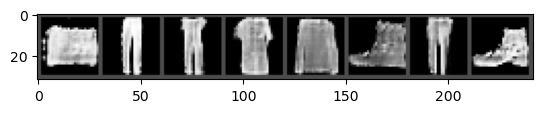

In [9]:
rand_num = torch.randn(8, 100,1,1, device=device)
gen_pics = G(rand_num)
show_imgs(gen_pics)

In [10]:
fixed_noise = torch.randn(8, 100, device=device)
fixed_noise =fixed_noise.repeat(5, 1)

rand_val = 0.1
pos = 0
for i in range(40):
    fixed_noise[i][pos] = rand_val
    if i % 8 == 7:
        pos += 20
x_gen = G(fixed_noise)
show_imgs(x_gen)

rand_val = 10
pos = 0
for i in range(40):
    fixed_noise[i][pos] = rand_val
    if i % 8 == 7:
        pos += 20
x_gen = G(fixed_noise)
show_imgs(x_gen)

rand_val = 100
pos = 0
for i in range(40):
    fixed_noise[i][pos] = rand_val
    if i % 8 == 7:
        pos += 20
x_gen = G(fixed_noise)
show_imgs(x_gen)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [40, 100]